<a href="https://colab.research.google.com/github/hmit208/stock-analysis-20191/blob/master/Stock_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# initial configs

## preprocessing

In [1]:
!git clone https://github.com/hmit208/stock-analysis-20191

Cloning into 'stock-analysis-20191'...
remote: Enumerating objects: 137, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 137 (delta 12), reused 127 (delta 6), pack-reused 0
Receiving objects: 100% (137/137), 5.38 MiB | 7.69 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [2]:
cd stock-analysis-20191/

/content/stock-analysis-20191


In [0]:
# !python3 preprocessing.py

[[47900. 47700. 48400. 48600. 48100.]
 [47700. 48400. 48600. 48100. 47800.]
 [48400. 48600. 48100. 47800. 47500.]
 ...
 [53000. 54400. 53700. 52800. 52100.]
 [54400. 53700. 52800. 52100. 52700.]
 [53700. 52800. 52100. 52700. 53100.]]
NUMBER VALID:  50


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch import nn, optim
from torch.autograd.variable import Variable
from sklearn.preprocessing import StandardScaler
from math import sqrt
from configs import *
# BID, FPT, GAS, HPG, MBB, VCB, VIC
df = pd.read_csv(
    '../FPT.csv')

# setting index as date
df['Date'] = pd.to_datetime(df.Date, format='%d/%m/%Y')
df.index = df['Date']

In [27]:
df

,Unnamed: 0,Date,Close,VWAP,Open,Volume,High,Low,BuyQuantity,SellQuantity,ROE,EPS
Date,,,,,,,,,,,,
2019-08-30,0,2019-08-30,77700,77517.58,77000,280130,77700,77000,0,0,25.48,4658.84
2019-08-29,1,2019-08-29,76800,76785.71,76900,422240,77400,76500,965790,563110,25.48,4658.84
2019-08-28,2,2019-08-28,77000,77055.42,76800,588810,77300,76800,1099180,893690,25.48,4658.84
2019-08-27,3,2019-08-27,76500,77348.45,78200,1116480,78800,76000,1773870,1729610,25.48,4658.84
2019-08-26,4,2019-08-26,77800,78031.00,78200,672220,78600,77500,1235290,1287730,25.48,4658.84
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-01-08,908,2016-01-08,42200,42150.40,42400,676340,42600,41700,1533660,1138010,25.48,4658.84
2016-01-07,909,2016-01-07,42500,42536.29,42800,935460,42900,42000,1733430,1457390,25.48,4658.84
2016-01-06,910,2016-01-06,43000,42784.03,42500,699490,43200,42500,1419150,1022920,25.48,4658.84


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


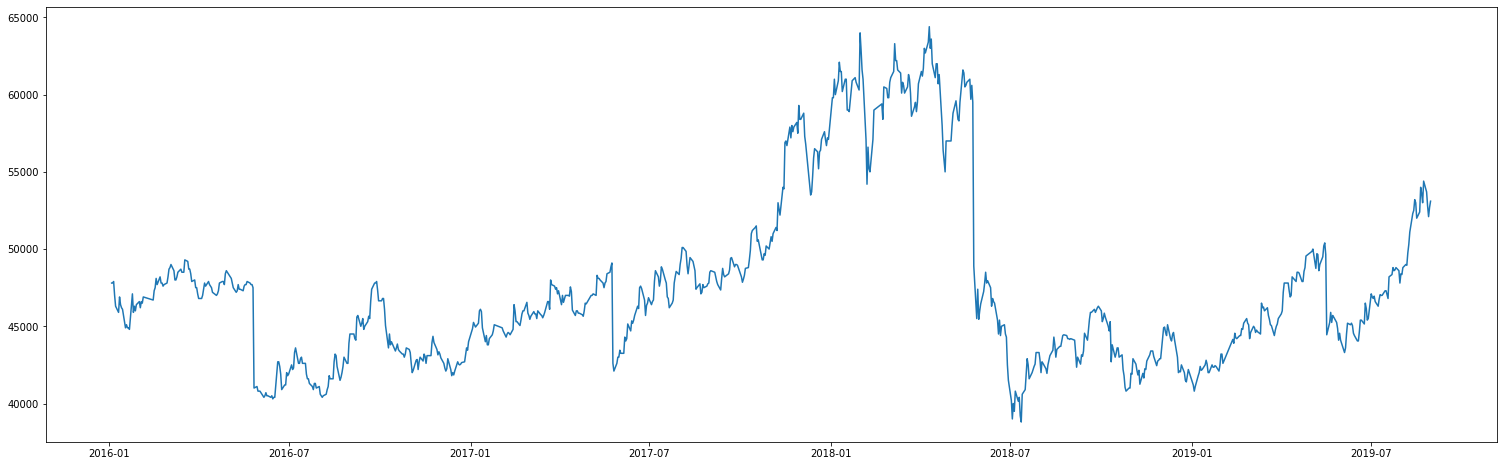

In [6]:
plt.figure(figsize=(26, 8))
plt.plot(df['Close'], label='Close Price history')
plt.show()

In [0]:
cols = ['Date', 'Close', 'High', 'Low', 'Volume']


In [0]:
# data mới only
new_data = df.sort_index(ascending=True, axis=0)
data = df.sort_index(ascending=True, axis=0)


In [0]:
cols = ['Date', 'Close', 'Volume', 'Open', 'High', 'Low']

In [0]:
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0, len(df)), columns=cols)
for i in range(0, len(data)):
    for col in cols:
        new_data[col][i] = data[col][i]

In [0]:
# setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

dataset = new_data.values

sma_short_time = new_data['Close'].rolling(window=short_time).mean()
sma_long_time = new_data['Close'].rolling(window=long_time).mean()
exp_short_time = new_data['Close'].ewm(span=short_time, adjust=False).mean()
exp_long_time = new_data['Close'].ewm(span=long_time, adjust=False).mean()

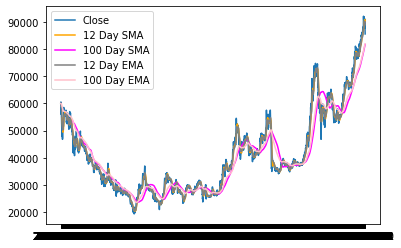

In [42]:
plt.plot(data['Date'], new_data['Close'], label='Close')
plt.plot(data['Date'], sma_short_time, label='12 Day SMA', color='orange')
plt.plot(data['Date'], sma_long_time, label='100 Day SMA', color='magenta')
plt.plot(data['Date'], exp_short_time, label='12 Day EMA', color='gray')
plt.plot(data['Date'], exp_long_time, label='100 Day EMA', color='pink')
plt.legend(loc='upper left')
plt.show()

In [0]:
# Adding features
new_data['sma_short_time'] = sma_short_time
# new_data['sma_long_time'] = sma_long_time
new_data['exp_short_time'] = exp_short_time
# new_data['exp_long_time'] = exp_long_time


In [0]:
_input_dim = new_data.shape[1]
lstm_params['input_dim'] = _input_dim
# print("lstm_params['input_dim']: ", lstm_params['input_dim'])

new_data = new_data.dropna()
dataset = new_data.values

In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

scaler_labels = MinMaxScaler(feature_range=(0, 1))
# print("####: ", dataset[: , 0])
# print("$$$: ", dataset)
scaled_label_data = scaler_labels.fit_transform(dataset[: , 0].reshape(-1, 1))
# print("00000")
# print(scaler_labels.inverse_transform(scaled_label_data))

In [14]:
X = []
y = []

for i in range(time_prev, len(scaled_data)):
    if i + num_future_days <= len(scaled_label_data):
        X.append(scaled_data[i - time_prev:i, :])
        y.append(scaled_data[i: i + num_future_days, 0])
X, y = np.array(X), np.array(y)


X = torch.from_numpy(X)
y = torch.from_numpy(y)
y = y.view(len(y), num_future_days)

print(scaler_labels.inverse_transform(y))

# SPLIT = int(0.95 * len(X))
# SPLIT = len(X) - 150
SPLIT = int(len(X)*0.8)
X_train = X[0: SPLIT, :]
y_train = y[0: SPLIT, ]
X_valid = X[SPLIT:, :]
y_valid = y[SPLIT:, ]
print("NUMBER VALID: ", len(y_valid))
dataset_train = TensorDataset(X_train, y_train)
dataset_valid = TensorDataset(X_valid, y_valid)

train_loader = DataLoader(dataset=dataset_train, batch_size=lstm_params['batch_size'], shuffle=False)
test_loader = DataLoader(dataset=dataset_valid, batch_size=lstm_params['batch_size'], shuffle=False)

[[47900. 47700. 48400. 48600. 48100.]
 [47700. 48400. 48600. 48100. 47800.]
 [48400. 48600. 48100. 47800. 47500.]
 ...
 [53000. 54400. 53700. 52800. 52100.]
 [54400. 53700. 52800. 52100. 52700.]
 [53700. 52800. 52100. 52700. 53100.]]
NUMBER VALID:  167


In [16]:
len(X)*0.2

527.4

##LSTM

In [0]:
import torch
from torch import nn
# from preprocessing import train_loader, test_loader, scaler, scaler_labels
# from configs import *
# from preprocessing import *
import numpy as np
import random

In [0]:

device = device
input_dim = lstm_params['input_dim']
hidden_dim = lstm_params['hidden_dim']
num_layer = lstm_params['num_layer']
num_epochs = lstm_params['num_epochs']
batch_size = lstm_params['batch_size']
learning_rate = lstm_params['learning_rate']
output_dim = lstm_params['output_dim']
seq_len = lstm_params['seq_len']
bidirectional = lstm_params['bidirectional']
torch.manual_seed(9999)
np.random.seed(9999)
random.seed(9999)

In [17]:
device

device(type='cuda')

In [0]:
class LSTMNet(nn.Module):

    def __init__(self,
                 _input_dim,
                 _hidden_dim,
                 _output_dim,
                 _batch_size,
                 _device,
                 _num_layer=1,
                 _bidirectional=False):
        super(LSTMNet, self).__init__()
        self.input_dim = _input_dim
        self.hidden_dim = _hidden_dim
        self.output_dim = _output_dim
        self.batch_size = _batch_size
        self.device = _device
        self.num_layer = _num_layer
        self.bidirectional = _bidirectional

        self.lstm = nn.LSTM(input_size=self.input_dim, hidden_size=self.hidden_dim, num_layers=self.num_layer,
                            bidirectional=bidirectional)

        self.out = nn.Sequential(
            nn.Linear(self.hidden_dim, 64),
            nn.Dropout(0.2),
            nn.Linear(64, self.output_dim),
            nn.LeakyReLU(0.01)
        )

    def init_hidden(self):
        # 1*1 = num_layers*directions

        h0 = torch.zeros(self.num_layers * 1, self.batch_size, self.hidden_dim)
        c0 = torch.zeros(self.num_layers * 1, self.batch_size, self.hidden_dim)
        return h0, c0

    def forward(self, x):
        h0 = torch.zeros(1, x.size(1), self.hidden_dim).to(self.device)
        c0 = torch.zeros(1, x.size(1), self.hidden_dim).to(self.device)

        on, (hn, cn) = self.lstm(x.float(), (h0, c0))
        out = self.out(hn)
        return out

In [0]:
# define model
model = LSTMNet(_input_dim=input_dim,
                _hidden_dim=hidden_dim,
                _output_dim=output_dim,
                _batch_size=batch_size,
                _device=device).to(device)

# define loss function
criterion = nn.MSELoss()

# define opimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [0]:
def train():
    for epoch in range(num_epochs+1):

        for i, (features, labels) in enumerate(train_loader):
            features = features.to(device)
            features = features.view(seq_len, -1, input_dim)

            labels = labels.to(device).float()
            labels = labels.view(1, -1, output_dim)
            # compute forward
            outs = model(features)
            # print("outs: ", outs.size())

            # compute loss
            loss = criterion(outs, labels)

            # compute gradients
            optimizer.zero_grad()
            loss.backward()

            # update parameters
            optimizer.step()

        if epoch > 10:
            if epoch % 10 == 0:
                print("Epoch {}/{} -- Loss: {:.5}"
                      .format(epoch, num_epochs, loss.item()))
        else:
            print("Epoch {}/{} -- Loss: {:.5}"
                  .format(epoch + 1, num_epochs, loss.item()))
    torch.save(model.state_dict(), './model.pth')

In [0]:

def load_model(name):
    _model = LSTMNet(_input_dim=input_dim,
                    _hidden_dim=hidden_dim,
                    _output_dim=output_dim,
                    _batch_size=batch_size,
                    _device=device).to(device)
    _model.load_state_dict(torch.load('./'+name+'.pth'))
    _model.eval()
    print("Eval: ", model.eval())
    return _model

In [0]:
def test(model):
    with torch.no_grad():
        l = 0
        total = 0
        for features, true_labels in test_loader:
            total += len(true_labels) * num_future_days
            true_labels = true_labels.to(device).float()
            true_labels = true_labels.view(1, -1, output_dim)
            features = features.view(seq_len, -1, input_dim)
#             features2 = features.clone().to(device)
#             preds = model(features)
            preds = model(features.cuda()).clone()
            preds = preds.view(preds.size(1) * preds.size(2))
            preds = preds.cpu()
            true_labels = true_labels.cpu()
            true_labels = true_labels.view(true_labels.size(1) * true_labels.size(2))

            converted = scaler_labels.inverse_transform(preds.reshape(-1, 1))
            true = scaler_labels.inverse_transform(true_labels.reshape(-1, 1))
            print("invert: \n", converted.reshape(-1, output_dim))
            print("true label: \n", true.reshape(-1, output_dim))

            # print("labels: \n", labels)
            # print("out pred: \n", preds)

            ab = np.abs(preds - true_labels) / true_labels
            # print("ab: ", ab)
            ab = ab.numpy()
            # print(type(ab))
            l += np.sum(ab, axis=0)
            print("l: ", l)

            # print("----: \n", np.sum(np.abs(preds - labels)/labels))
            # loss = criterion(preds, labels)
            # total += loss
        print("total: ", total)
        mape = l / total

        print('Error with test: {}'.format(mape))

In [22]:
train()

Epoch 1/100 -- Loss: 0.041135
Epoch 2/100 -- Loss: 0.0046864
Epoch 3/100 -- Loss: 0.028363
Epoch 4/100 -- Loss: 0.01673
Epoch 5/100 -- Loss: 0.0052199
Epoch 6/100 -- Loss: 0.0094808
Epoch 7/100 -- Loss: 0.0029052
Epoch 8/100 -- Loss: 0.0079819
Epoch 9/100 -- Loss: 0.0023279
Epoch 10/100 -- Loss: 0.0087492
Epoch 11/100 -- Loss: 0.0022435
Epoch 20/100 -- Loss: 0.0023727
Epoch 30/100 -- Loss: 0.002226
Epoch 40/100 -- Loss: 0.0020048
Epoch 50/100 -- Loss: 0.0027345
Epoch 60/100 -- Loss: 0.0018651
Epoch 70/100 -- Loss: 0.0017477
Epoch 80/100 -- Loss: 0.0025836
Epoch 90/100 -- Loss: 0.0024483
Epoch 100/100 -- Loss: 0.0019124


In [0]:
lstm_params

In [0]:
load_model()

In [23]:
test(load_model('model'))

Eval:  LSTMNet(
  (lstm): LSTM(6, 128)
  (out): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=64, out_features=5, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
  )
)
invert: 
 [[42467.029953   42542.53921509 42488.66043091 42571.54273987
  42581.35108948]
 [42381.89315796 42455.37834167 42395.95756531 42472.99613953
  42477.93998718]
 [42442.65823364 42520.68595886 42453.75823975 42525.35705566
  42531.40907288]
 [42306.6986084  42370.04623413 42292.34466553 42360.44921875
  42341.44363403]
 [41662.70885468 41760.29586792 41704.78229523 41788.62934113
  41825.20885468]
 [41715.67230225 41803.59077454 41735.27412415 41812.01858521
  41819.21901703]
 [41985.87417603 42068.16825867 41998.1300354  42064.71138
  42074.88708496]
 [42104.07752991 42186.30142212 42113.68141174 42175.92849731
  42187.68501282]
 [41620.14560699 41701.88865662 41631.85882568 41707.4131012
  41719.25125122]
 [41293.3

In [0]:
model = load_model('lstm_model_BID')

Eval:  LSTMNet(
  (lstm): LSTM(6, 128)
  (out): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=64, out_features=5, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
  )
)


In [0]:
test(model)

In [24]:
with torch.no_grad():
        l = 0
        total = 0
        all_preds = []
        all_true = []
        for features, true_labels in test_loader:
            total += len(true_labels) * num_future_days
            true_labels = true_labels.to(device).float()
            true_labels = true_labels.view(1, -1, output_dim)
            features = features.view(seq_len, -1, input_dim)
#             features2 = features.clone().to(device)
#             preds = model(features)
            preds = model(features.cuda()).clone()
            preds = preds.view(preds.size(1) * preds.size(2))
            preds = preds.cpu()
            true_labels = true_labels.cpu()
            true_labels = true_labels.view(true_labels.size(1) * true_labels.size(2))

            converted = scaler_labels.inverse_transform(preds.reshape(-1, 1))
            true = scaler_labels.inverse_transform(true_labels.reshape(-1, 1))
            # print("invert: \n", converted.reshape(-1, output_dim))
            # print("true label: \n", true.reshape(-1, output_dim))
            temp_pred = [x[0] for x in converted.reshape(-1, output_dim)]
            temp_true = [x[0] for x in true.reshape(-1, output_dim)]
            all_preds+=(temp_pred)
            all_true+=(temp_true)

            # print("labels: \n", labels)
            # print("out pred: \n", preds)

            ab = np.abs(preds - true_labels) / true_labels
            # print("ab: ", ab)
            ab = ab.numpy()
            # print(type(ab))
            l += np.sum(ab, axis=0)
            print("l: ", l)

            # print("----: \n", np.sum(np.abs(preds - labels)/labels))
            # loss = criterion(preds, labels)
            # total += loss
        print("total: ", total)
        mape = l / total
        print(all_preds)

        print('Error with test: {}'.format(mape))

l:  25.699249267578125
l:  40.19820976257324
l:  64.48006439208984
l:  89.27352523803711
l:  99.93128967285156
l:  102.42961049079895
total:  835
[42467.02995300293, 42381.893157958984, 42442.65823364258, 42306.69860839844, 41662.70885467529, 41715.672302246094, 41985.87417602539, 42104.07752990723, 41620.14560699463, 41293.39828491211, 41239.069747924805, 41831.57196044922, 41845.97969055176, 42137.13188171387, 42082.7033996582, 42145.52230834961, 42226.70555114746, 42421.58393859863, 42473.72703552246, 42128.8516998291, 42169.17686462402, 42451.242446899414, 42373.86169433594, 42233.24089050293, 42403.750228881836, 42373.99559020996, 42191.56723022461, 42355.24215698242, 42968.547439575195, 43082.662200927734, 42528.67393493652, 43666.36848449707, 43889.28527832031, 44278.782653808594, 44169.61975097656, 43963.69400024414, 44033.18862915039, 44432.30781555176, 44462.52136230469, 44444.05517578125, 44803.9909362793, 45359.93194580078, 44930.43975830078, 44866.748046875, 44479.57038879

In [26]:
x = np.abs(np.asarray(all_preds) - np.asarray(all_true)) / np.asarray(all_true)
np.sum(x)*5/835

0.011012655433129006

In [60]:
from sklearn.metrics import mean_squared_error
sqrt(mean_squared_error(all_true,all_preds))

4871.4329851318225

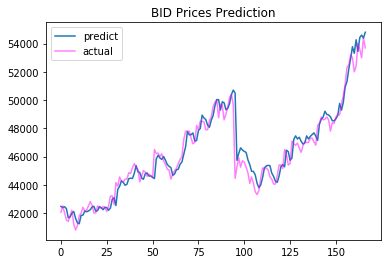

In [27]:
# plt.figure(figsize=(26, 8))
plt.plot(all_preds, label='predict')
plt.plot(all_true, label='actual', color='magenta', alpha=0.5)
plt.legend(loc='upper left')
plt.title('BID Prices Prediction')
plt.savefig('BID2_051219.png')
plt.show()


# test

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('./raw/AAA.csv')

In [0]:
df['Date'] = pd.to_datetime(df.Date, format='%d/%m/%Y')
df.index = df['Date']
df

,Unnamed: 0,Date,Close,VWAP,Open,Volume,High,Low,BuyQuantity,SellQuantity,ROE,EPS
Date,,,,,,,,,,,,
2019-08-30,0,2019-08-30,16400,16175.09,15900,2733710,16400,15900,0,0,15.23,2570.94
2019-08-29,1,2019-08-29,15800,15976.97,16050,2051390,16150,15800,3252460,4038680,15.23,2570.94
2019-08-28,2,2019-08-28,16050,16163.97,16250,1701810,16400,16050,2761140,4255790,15.23,2570.94
2019-08-27,3,2019-08-27,16250,16379.30,16550,2401690,16650,16200,4057610,5184790,15.23,2570.94
2019-08-26,4,2019-08-26,16500,16577.87,16850,2466420,16900,16300,3647220,5348270,15.23,2570.94
2019-08-23,5,2019-08-23,16950,16916.94,16900,904360,17050,16800,1967590,2805260,15.23,2570.94
2019-08-22,6,2019-08-22,16900,16990.78,16950,1181170,17100,16900,2536840,3745240,15.23,2570.94
2019-08-21,7,2019-08-21,16900,16907.63,16850,2408380,17050,16700,3984130,4585010,15.23,2570.94
2019-08-20,8,2019-08-20,16850,16952.04,16950,1504480,17150,16850,2697210,4043890,15.23,2570.94


Date
2019-08-30    16400
2019-08-29    15800
2019-08-28    16050
2019-08-27    16250
2019-08-26    16500
2019-08-23    16950
2019-08-22    16900
2019-08-21    16900
2019-08-20    16850
2019-08-19    16950
2019-08-16    17050
2019-08-15    17200
2019-08-14    17200
2019-08-13    17400
2019-08-12    17400
2019-08-09    17600
2019-08-08    17500
2019-08-07    17450
2019-08-06    17400
2019-08-05    17550
2019-08-02    17850
2019-08-01    17950
2019-07-31    17900
2019-07-30    18250
2019-07-29    18350
2019-07-26    18700
2019-07-25    18950
2019-07-24    18700
2019-07-23    18700
2019-07-22    18600
              ...  
2016-02-19    15000
2016-02-18    15100
2016-02-17    15000
2016-02-16    14800
2016-02-15    14800
2016-02-05    14200
2016-02-04    14300
2016-02-03    14200
2016-02-02    14400
2016-02-01    14200
2016-01-29    13600
2016-01-28    14200
2016-01-27    14100
2016-01-26    14000
2016-01-25    15500
2016-01-22    15500
2016-01-21    15700
2016-01-20    14700
2016-01-19    1

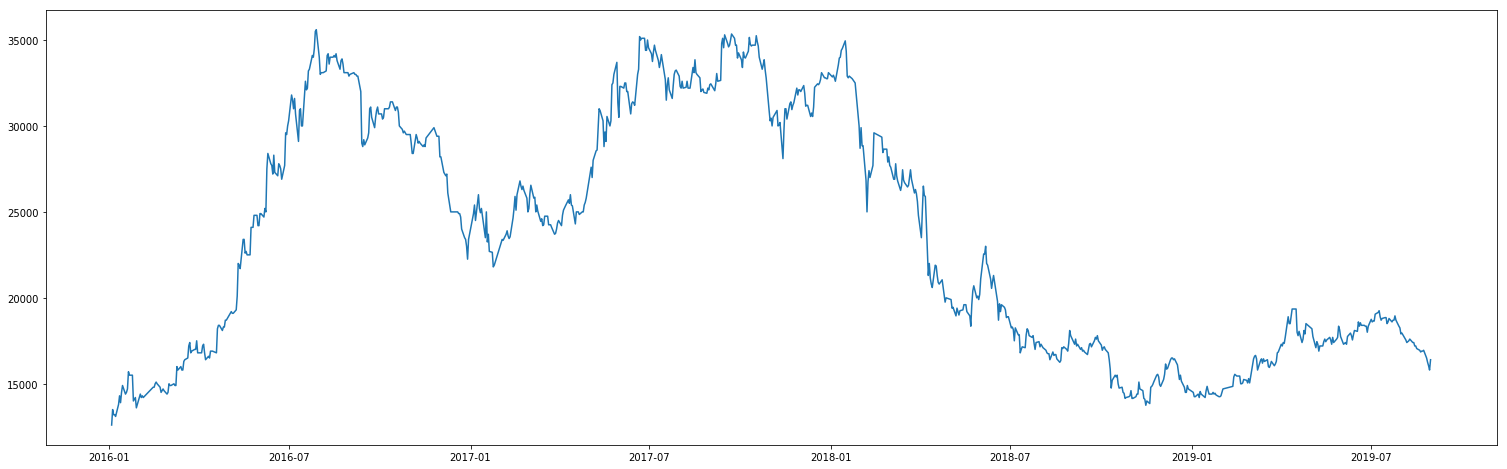

In [0]:

plt.figure(figsize=(26, 8))
plt.plot(df['Close'], label='Close Price history')
print(df['Close'])
plt.show()

In [0]:
from configs import *

data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0, len(df)), columns=cols)
for i in range(0, len(data)):
    for col in cols:
        new_data[col][i] = data[col][i]

In [0]:
# setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)


In [0]:
new_data

,Close,Volume
Date,,
2016-01-04,12600,324250
2016-01-05,13500,1842018
2016-01-06,13200,249405
2016-01-07,13200,334090
2016-01-08,13100,168020
2016-01-11,13800,614427
2016-01-12,14300,916709
2016-01-13,13900,189045
2016-01-14,14500,802285


In [0]:
sma_short_time = new_data['Close'].rolling(window=short_time).mean()
sma_long_time = new_data['Close'].rolling(window=long_time).mean()
exp_short_time = new_data['Close'].ewm(span=short_time, adjust=False).mean()
exp_long_time = new_data['Close'].ewm(span=long_time, adjust=False).mean()
sma_short_time

Date
2016-01-04             NaN
2016-01-05             NaN
2016-01-06             NaN
2016-01-07             NaN
2016-01-08             NaN
2016-01-11             NaN
2016-01-12             NaN
2016-01-13             NaN
2016-01-14             NaN
2016-01-15             NaN
2016-01-18             NaN
2016-01-19    13825.000000
2016-01-20    14000.000000
2016-01-21    14183.333333
2016-01-22    14375.000000
2016-01-25    14566.666667
2016-01-26    14641.666667
2016-01-27    14666.666667
2016-01-28    14658.333333
2016-01-29    14633.333333
2016-02-01    14608.333333
2016-02-02    14566.666667
2016-02-03    14550.000000
2016-02-04    14533.333333
2016-02-05    14491.666667
2016-02-15    14416.666667
2016-02-16    14358.333333
2016-02-17    14316.666667
2016-02-18    14408.333333
2016-02-19    14483.333333
                  ...     
2019-07-22    18837.500000
2019-07-23    18808.333333
2019-07-24    18770.833333
2019-07-25    18745.833333
2019-07-26    18729.166667
2019-07-29    18700.000

NameError: ignored

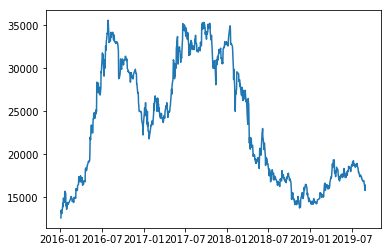

In [0]:
plt.plot(data['Date'], new_data['Close'], label='Close')
plt.plot(data['Date'], rolling_mean, label='12 Day SMA', color='orange')
plt.plot(data['Date'], rolling_mean2, label='100 Day SMA', color='magenta')
plt.plot(data['Date'], exp1, label='12 Day EMA', color='gray')
plt.plot(data['Date'], exp2, label='100 Day EMA', color='pink')
plt.legend(loc='upper left')
plt.show()

In [0]:
# Adding features
new_data['sma_short_time'] = sma_short_time
# new_data['sma_long_time'] = sma_long_time
new_data['exp_short_time'] = exp_short_time
# new_data['exp_long_time'] = exp_long_time

In [0]:

_input_dim = new_data.shape[1]
lstm_params['input_dim'] = _input_dim
print("lstm_params['input_dim']: ", lstm_params['input_dim'])

lstm_params['input_dim']:  4


In [0]:
new_data = new_data.dropna()
from sklearn.preprocessing import MinMaxScaler
dataset = new_data.values

In [0]:
new_data

,Close,Volume,sma_short_time,exp_short_time
Date,,,,
2016-01-19,14500,306011,13825.000000,13935.509239
2016-01-20,14700,821924,14000.000000,14053.123202
2016-01-21,15700,876915,14183.333333,14306.488863
2016-01-22,15500,397410,14375.000000,14490.105961
2016-01-25,15500,415210,14566.666667,14645.474275
2016-01-26,14000,667213,14641.666667,14546.170540
2016-01-27,14100,540042,14666.666667,14477.528919
2016-01-28,14200,180725,14658.333333,14434.832162
2016-01-29,13600,327977,14633.333333,14306.396445


In [0]:
dataset

array([[14500, 306011, 13825.0, 13935.509238784118],
       [14700, 821924, 14000.0, 14053.1232020481],
       [15700, 876915, 14183.333333333334, 14306.488863271468],
       ...,
       [16050, 1701810, 16850.0, 16802.321845860002],
       [15800, 2051390, 16716.666666666668, 16648.118484958464],
       [16400, 2733710, 16650.0, 16609.94641034947]], dtype=object)

In [0]:
from sklearn.preprocessing import MinMaxScaler


# print(dataset[int(0.95 * len(dataset)):, :])

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

scaler_labels = MinMaxScaler(feature_range=(0, 1))
# print("####: ", dataset[: , 0])
# print("$$$: ", dataset)
scaled_label_data = scaler_labels.fit_transform(dataset[: , 0].reshape(-1, 1))
# print("00000")
# print(scaler_labels.inverse_transform(scaled_label_data))


In [0]:


# x_train, y_train = [], []

X = []
y = []

for i in range(time_prev, len(scaled_data)):
    if i + num_future_days <= len(scaled_label_data):
        X.append(scaled_data[i - time_prev:i, :])
        y.append(scaled_data[i: i + num_future_days, 0])
X, y = np.array(X), np.array(y)


X = torch.from_numpy(X)
y = torch.from_numpy(y)
y = y.view(len(y), num_future_days)

print(scaler_labels.inverse_transform(y))

[[18300. 18300. 18700. 18700. 19200.]
 [18300. 18700. 18700. 19200. 19100.]
 [18700. 18700. 19200. 19100. 19100.]
 ...
 [16900. 16950. 16500. 16250. 16050.]
 [16950. 16500. 16250. 16050. 15800.]
 [16500. 16250. 16050. 15800. 16400.]]


In [0]:
import pandas as pd
import numpy as np

df = pd.DataFrame({'B': [0, 1, 2, np.nan, 4]})

In [0]:
df.ewm(com=0.5).mean()

,B
0,0.000000
1,0.750000
2,1.615385
3,1.615385
4,3.670213


In [0]:
s = pd.Series(np.random.randn(1000),index=pd.date_range('1/1/2017', periods=1000))

In [0]:
 s = s.cumsum()
 s

In [0]:
r= s.rolling(window=100)

In [0]:
r.mean()

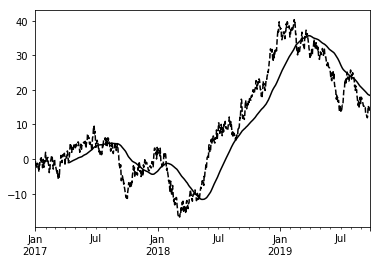

In [0]:
r.mean().plot(style='k')
s.plot(style='k----')

In [0]:
pip install dynet

     |████████████████████████████████| 28.1MB 41.3MB/s 


In [0]:
import dynet as dy
pc = dy.ParameterCollection()
NUM_LAYERS=2
INPUT_DIM=50
HIDDEN_DIM=10
builder = dy.LSTMBuilder(NUM_LAYERS, INPUT_DIM, HIDDEN_DIM, pc)

In [0]:
s0 = builder.initial_state()


In [0]:
x1 = dy.vecInput(INPUT_DIM)

In [0]:
x1.npvalue()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [0]:
s1=s0.add_input(x1)
y1 = s1.output()

In [0]:
print(s1.h())

(expression 92/0, expression 105/0)


In [0]:
y1.npvalue().shape

(10,)

In [0]:
s2=s1.add_input(x1) # we can add another input
y2=s2.output()

In [0]:
print(s2.h())

(expression 120/0, expression 135/0)


In [0]:
# create a simple rnn builder
rnnbuilder=dy.SimpleRNNBuilder(NUM_LAYERS, INPUT_DIM, HIDDEN_DIM, pc)

# initialize a new graph, and a new sequence
rs0 = rnnbuilder.initial_state()

# add inputs
rs1 = rs0.add_input(x1)
ry1 = rs1.output()
print("all layers:", s1.h())

all layers: (expression 92/0, expression 105/0)


In [0]:
print(rs1.s())

(expression 143/0, expression 145/0)


In [0]:
print(s1.s())


(expression 90/0, expression 103/0, expression 92/0, expression 105/0)


In [0]:

rnn_h  = rs1.h()
rnn_s  = rs1.s()
print("RNN h:", rnn_h)
print("RNN s:", rnn_s)


lstm_h = s1.h()
lstm_s = s1.s()
print("LSTM h:", lstm_h)
print("LSTM s:", lstm_s
)

RNN h: (expression 143/0, expression 145/0)
RNN s: (expression 143/0, expression 145/0)
LSTM h: (expression 92/0, expression 105/0)
LSTM s: (expression 90/0, expression 103/0, expression 92/0, expression 105/0)


In [0]:
s2=s1.add_input(x1)
s3=s2.add_input(x1)
s4=s3.add_input(x1)

# let's continue s3 with a new input.
s5=s3.add_input(x1)

# we now have two different sequences:
# s0,s1,s2,s3,s4
# s0,s1,s2,s3,s5
# the two sequences share parameters.

assert(s5.prev() == s3)
assert(s4.prev() == s3)

s6=s3.prev().add_input(x1)
# we now have an additional sequence:
# s0,s1,s2,s6

In [0]:
s6.h()

(expression 280/0, expression 295/0)

In [0]:
s6.s()

(expression 278/0, expression 293/0, expression 280/0, expression 295/0)

In [0]:
state = rnnbuilder.initial_state()
xs = [x1,x1,x1]
states = state.add_inputs(xs)
outputs = [s.output() for s in states]
hs =      [s.h() for s in states]
print(outputs, hs)

[expression 299/0, expression 303/0, expression 307/0] [(expression 297/0, expression 299/0), (expression 301/0, expression 303/0), (expression 305/0, expression 307/0)]


In [0]:
import random
from collections import defaultdict
from itertools import count
import sys

LAYERS = 1
INPUT_DIM = 50
HIDDEN_DIM = 50

characters = list("abcdefghijklmnopqrstuvwxyz ")
characters.append("<EOS>")

int2char = list(characters)
char2int = {c:i for i,c in enumerate(characters)}

VOCAB_SIZE = len(characters)

In [0]:

pc = dy.ParameterCollection()


srnn = dy.SimpleRNNBuilder(LAYERS, INPUT_DIM, HIDDEN_DIM, pc)
lstm = dy.LSTMBuilder(LAYERS, INPUT_DIM, HIDDEN_DIM, pc)

# add parameters for the hidden->output part for both lstm and srnn
params_lstm = {}
params_srnn = {}
for params in [params_lstm, params_srnn]:
    params["lookup"] = pc.add_lookup_parameters((VOCAB_SIZE, INPUT_DIM))
    params["R"] = pc.add_parameters((VOCAB_SIZE, HIDDEN_DIM))
    params["bias"] = pc.add_parameters((VOCAB_SIZE))

# return compute loss of RNN for one sentence
def do_one_sentence(rnn, params, sentence):
    # setup the sentence
    dy.renew_cg()
    s0 = rnn.initial_state()


    R = params["R"]
    bias = params["bias"]
    lookup = params["lookup"]
    sentence = ["<EOS>"] + list(sentence) + ["<EOS>"]
    sentence = [char2int[c] for c in sentence]
    s = s0
    loss = []
    for char,next_char in zip(sentence,sentence[1:]):
        s = s.add_input(lookup[char])
        probs = dy.softmax(R*s.output() + bias)
        loss.append( -dy.log(dy.pick(probs,next_char)) )
    loss = dy.esum(loss)
    return loss


# generate from model:
def generate(rnn, params):
    def sample(probs):
        rnd = random.random()
        for i,p in enumerate(probs):
            rnd -= p
            if rnd <= 0: break
        return i

    # setup the sentence
    dy.renew_cg()
    s0 = rnn.initial_state()

    R = params["R"]
    bias = params["bias"]
    lookup = params["lookup"]

    s = s0.add_input(lookup[char2int["<EOS>"]])
    out=[]
    while True:
        probs = dy.softmax(R*s.output() + bias)
        probs = probs.vec_value()
        next_char = sample(probs)
        out.append(int2char[next_char])
        if out[-1] == "<EOS>": break
        s = s.add_input(lookup[next_char])
    return "".join(out[:-1]) # strip the <EOS>


# train, and generate every 5 samples
def train(rnn, params, sentence):
    trainer = dy.SimpleSGDTrainer(pc)
    for i in range(200):
        loss = do_one_sentence(rnn, params, sentence)
        loss_value = loss.value()
        loss.backward()
        trainer.update()
        if i % 5 == 0:
            print("%.10f" % loss_value, end="\t")
            print(generate(rnn, params))

In [0]:
train(srnn, params_srnn, "these pretzels are making me thirsty")


228.3713684082	a quick brown fox jumped over the lazy dog
137.5572509766	a quick brown foe jityedogdo the oher tfed azy  og
126.7819824219	a quick brownvfox jump brrola box lumped rver the lazy the lazy the lazy the lazy theclazy dop
85.8594360352	a quick brown aoqtjcoglher the laze dog
50.6444702148	a quick bre nhbovthe lazy dog
35.0355873108	a quick brewn mretyel a
15.6349086761	aheltrv or the tai thi
5.9017581940	tzeserbrntzelthe qazyetme cveo the toe laztue paq jdog tre taethe pviretzr the lazeseosthi the lagthire prqth loil goee are nrithesqazy dmewmhe tairo awe zrxty fox juickzervthe tvesseze trg
3.3740730286	these pr thels are makisg me thersta
1.4845247269	ahqsp pretzelstaze making mesthirsty
0.5416691899	these nretzels are making me thirsty
0.3738350272	these pretzels are making me thirsty ere prstzess ty thirwmmee ma thels are making me thirsty
0.2871523499	these pretzels are making me thirsty
0.2335323989	these pretzels are making me thirsty
0.1969504356	these pretzels are m

In [0]:
sentence = "a quick brown fox jumped over the lazy dog"
train(srnn, params_srnn, sentence)

150.8297424316	djlnzifzlqnakk jjtpzih
104.8359146118	outzijnqdeodrvepwibhdcdmppsrnmhqreadidkxn f q
76.5366973877	kxe aumtaucua juwdv ybv x lengnvx adoejljvsb tjj cei tcvyn zetfo jqhprqomcowzxdxe nhag  azlijywqje zov anelu fhqpjyce wro ao dt
46.4170036316	ox jqofld ubdrdeoeo oxiogomnubtakvq pcwce aawjj
24.9672279358	g
10.9562282562	qci k k i fux jdgzk bofkb lo
4.0938439369	a qui k zrmwn fox a dpedcover the lazy dog
1.3587878942	a quick brown fox jumped over the lazy dog
0.8377645016	a quick brown fox jumped over the lazy dog
0.6067209244	a quick brown fox jumped over the lazy dog
0.4750170410	a quick brown fox jumped over the lazy dog
0.3898694515	a quick brown fox jumped over tqe lazy dog
0.3303213418	a quick brown fox jumped over the lazy dog
0.2863587737	a quick brown fox jumped over the lazy dog
0.2525878549	a quimk brown qox jumped over the lazy dog
0.2258438468	a quick brown fox jumped over the lazy dog
0.2041476965	a quick brown fox jumped over the lazy dog
0.1861978620	a quick b

In [0]:

sentence = "a quick brown fox jumped over the lazy dog"
train(lstm, params_lstm, sentence)

146.6510162354	l
129.2171325684	a
123.5400238037	odagsg jo
116.6974945068	pvevqw  urf kn dro vfqe jone  uoverahhl
111.6722564697	io wjaienyrv mudoflemeete  mdd ge
103.6491165161	kskbwnr fcfoexwoexwvoej  eha
97.9149093628	kl  bnncxwvo jeomeerepe vehey ygta aayoodoavd yc zeoro
91.1067733765	abcijw d kxonbx uuumd  upqe v deeove ye gwylaz zgjdtdg ggeowades zv ae
83.8098526001	by ufcvo lg vk cun trfh doer z ge   lh i loo ygdjhdy  h
78.2266921997	iwnru ox mr muoe en dooee hdz zyl otatodgg
70.3645477295	e qari rrr bn fw
61.8785324097	iy uk b bbfr noeu ve
55.8658142090	ojujcn for ojjpmrdvdrvrye hltvell
49.5231018066	 q uuicw brn iofoxw fujpudde d ter ta elazzy og
42.7934341431	wb cruooww ox pe p udgmooe tee ld bo
37.0275878906	y icccdobxw fnox eoxee oveh ddove vgrz tzld h
31.2712097168	a uic kobrow ff oxjie oove ove haz y dog
26.3221778870	z qku brbrn foox jx umppoed thze zzy ly doggr
22.3249568939	 uqu qckkfown foxjme jee
18.2457771301	 quauki broknn nn pn mmed over the lazy dog
14.6081705093

In [0]:
import os
import urllib
import gzip
import _pickle as cPickle
import numpy as np
DATA_PATH = './tmp'
DATA_FILENAME = 'mnist.pkl.gz'
DATA_FILE = DATA_PATH + '/' + DATA_FILENAME
def download():
  '''
  Download MNIST dataset
  '''
  # create data dir if not exist
  if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)
  
  # download
  url = 'https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz'
  input = urllib.request.urlopen(url)
  with open(DATA_FILE, 'wb') as output:
    while True:
      data = input.read(4096)
      if data:
        output.write(data)
      else:
        break
    print('Downloaded MNIST dataset: '+ DATA_FILE)

In [0]:
def load():
  '''
  Load MNIST dataset.
  This will return tuple of (training_data, validation_data, test_data)
  ``training_data`` is a list of 50,000 training data. Each sample is a tuple ``(x, y)``.
  ``x`` is a 784-dim np.ndarray contains the input image, and ``y`` is a 10-dim np.ndarray for one-hot label vector.
  ``validataion_test`` and ``test_data`` are lists of 10,000 validataion and test data.
  The structure is similar to ``training_data``, except ``y`` is a number corresponding to ``x`` input image.
  '''
  # download data if not exist
  if not os.path.exists(DATA_FILE):
    download()
  
  # load data
  with gzip.open(DATA_FILE, 'rb') as file:
    tr_dt, v_dt, t_dt = cPickle.load(file, encoding='latin1')
  
  # training data
  inputs = [x.reshape((784, 1)) for x in tr_dt[0]]
  labels = [label_2_vec(y) for y in tr_dt[1]]
  training_data = zip(inputs, labels)
  
  # validation data
  inputs = [x.reshape((784, 1)) for x in v_dt[0]]
  validation_data = zip(inputs, v_dt[1])
  
  # test data
  inputs = [x.reshape((784, 1)) for x in t_dt[0]]
  test_data = zip(inputs, t_dt[1])
  
  return (training_data, validation_data, test_data)


In [0]:
def label_2_vec(label):
  '''
  One-hot label vector
  '''
  v = np.zeros((10, 1))
  v[label] = 1.0
  return v

In [0]:
training_data, validation_data, test_data = load()

In [0]:
  with gzip.open(DATA_FILE, 'rb') as file:
    tr_dt, v_dt, t_dt = cPickle.load(file, encoding='latin1')

In [0]:
inputs = [x.reshape((784, 1)) for x in tr_dt[0]]

In [0]:
inputs[0][700]

array([0.], dtype=float32)

In [0]:
from __future__ import division
import random
import time
import numpy as np

In [0]:
class NN():
    def __init__(self, layers):
        """
        Init NN with ``layers`` size.
        ``layers`` is array of layer sizes.
        E.x: [3, 4, 5, 2] will create a NN of 4 layers.
        In which,
          input layer containts 3 nodes,
         hidden layer 1 contains 4 nodes, 
         hidden layer 2 contains 5 nodes, 
         and, output layer contains 2 nodes
        """
        self.layers = layers
        self.L = len(layers)
        # ``w `` is a list (L-1) dim np.ndarray of matrix W for each layers
        # ``w[0]` is layer 2 (hidden layer 1), ..., ``w[L-2]`` is output layer 
        # Each row hold weights for inputs (from before layer) of correspoding node (on current layer)
        # The first column is bias for correspoding node
        self.w = [np.random.randn(l2, l1 + 1) for l2, l1 in zip(layers[1:], layers[:-1])]
        
    def feedforward(self, x):
        z = []
        a = [self.add_bias(x)]
        for l in range(1, self.L):
            z_l = np.dot(self.w[l-1], a[l-1])
            a_l = self.sigmoid(z_l)
            if l < self.L - 1:
                a_l = self.add_bias(a_l)
            z.append(z_l)
            a.append(a_l) 
        return (z, a)

    def add_bias(self, a):
        """
        add a_0 = 1 as input for bias w_0
        """
        return np.insert(a, 0, 1, axis=0)

    def sigmoid(self, z):
        """
        Sigmoid function use as activation function
        """
        return 1.0 / (1.0 + np.exp(-z))

# test2

In [0]:
import sys
(lstm_params)
# for features, true_labels in test_loader:
#   print(features[0])
#   sys.exit()

{'batch_size': 32,
 'bidirectional': False,
 'hidden_dim': 128,
 'input_dim': 5,
 'learning_rate': 0.001,
 'num_epochs': 100,
 'num_layer': 1,
 'output_dim': 5,
 'seq_len': 64}

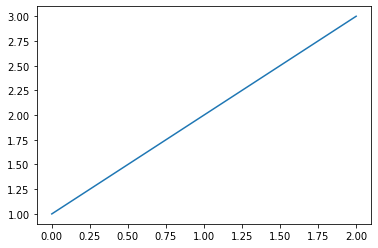

In [0]:
import matplotlib.pyplot as plt
plt.plot([1,2,3])
plt.show()